# Minicompetition Project
## Rossman 6 month sales Prediction
Here, we will go through a data challenge using data predicting Sales for Rossman. 



In [1]:
import numpy as np
import pandas as pd
# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter


import warnings
warnings.filterwarnings('ignore')
import plotly
sns.set_style('darkgrid')
import missingno as msno
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

In [2]:
import pickle

## 1. Initial Data Understanding
Here, we get to know our data and try to figure out next steps for modelling.

A goal in this step is to get to know what types of data cleaning, preparation and encoding we need to do in order to prepare our data for inclusion in a model.

Since we are predicting price, this is a supervised regression problem.

In [3]:
train = pd.read_csv('./data/train.csv')
store = pd.read_csv('./data/store.csv')

train.shape, store.shape

((637774, 9), (1115, 10))

In [4]:
train.shape

(637774, 9)

In [5]:
bins=[200,300,350,400,450,500,550,600,700,800,900,1200,1500,3500]

In [6]:
CustomerTraffic = pd.DataFrame(train.groupby('Store')['Customers'].mean())
CustomerTraffic.Customers.describe()


CustomerTraffic['CustomerTraffic'] = pd.cut(CustomerTraffic['Customers'], bins)

In [7]:
train['CustomerAverage'] = train['Sales']/train['Customers']

In [8]:
bins2 = [0,2,4,6,8,10,15,18,25,40,65]

In [9]:
CustomerCat = pd.DataFrame(train.groupby('Store')['CustomerAverage'].mean())
CustomerCat['CustomerCategory'] = pd.cut(CustomerCat['CustomerAverage'], bins2)


In [10]:
new_train = pd.merge(train, CustomerTraffic, how="left", on='Store')

In [11]:
new_train = pd.merge(new_train, CustomerCat, how="left", on='Store')

In [12]:
combined = pd.merge(new_train, store, how="left", on='Store')
combined.shape

(637774, 23)

In [13]:
combined.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers_x', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CustomerAverage_x', 'Customers_y',
       'CustomerTraffic', 'CustomerAverage_y', 'CustomerCategory', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [14]:
combined.drop(columns=['CustomerAverage_x', 'CustomerAverage_y', 'Customers_y'], inplace=True)

In [15]:
combined.StateHoliday.replace(0,'0', inplace=True)

In [16]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637774 entries, 0 to 637773
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   Date                       637774 non-null  object  
 1   Store                      618473 non-null  float64 
 2   DayOfWeek                  618757 non-null  float64 
 3   Sales                      618747 non-null  float64 
 4   Customers_x                618683 non-null  float64 
 5   Open                       618588 non-null  float64 
 6   Promo                      618580 non-null  float64 
 7   StateHoliday               618520 non-null  object  
 8   SchoolHoliday              618437 non-null  float64 
 9   CustomerTraffic            618473 non-null  category
 10  CustomerCategory           618473 non-null  category
 11  StoreType                  618473 non-null  object  
 12  Assortment                 618473 non-null  object  
 13  CompetitionDis

In [17]:
combined.Promo2.value_counts()

1.0    314828
0.0    303645
Name: Promo2, dtype: int64

<AxesSubplot:>

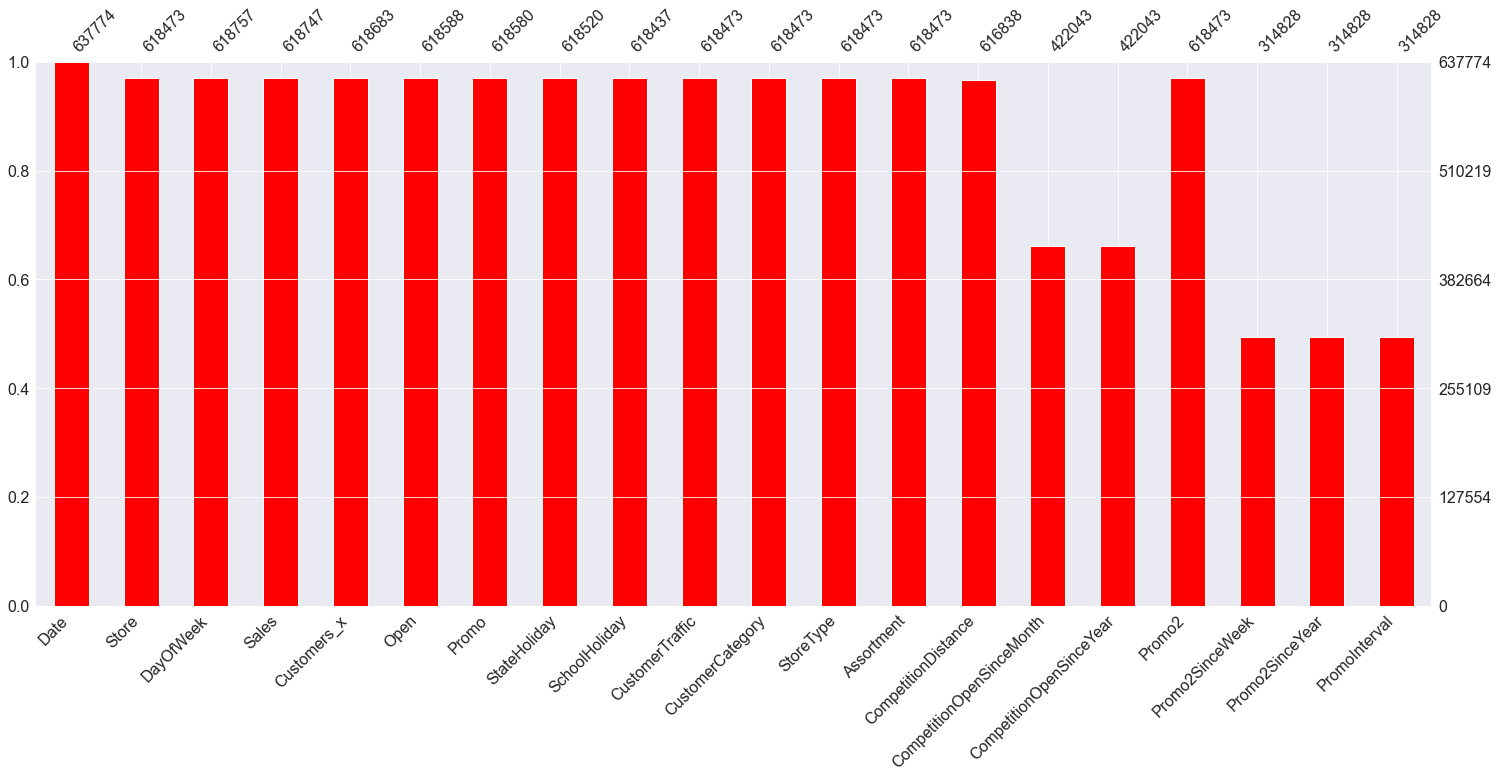

In [18]:
msno.bar(combined, color='red')

In [19]:
def compute_rmse(actual, prediction):
    """
    Computs RMSE (root mean squared error) between predictions from a model
    and the actual values of the target variable.
    """
    
    rmse = sqrt(mean_squared_error(actual, prediction))
    
    # rounding to 2 decimal places
    print('RMSE is ', round(rmse,2))
    
    return rmse



# def mean_encode(data, col, on):
#     group = data.groupby(col).mean()
#     mapper = {k: v for k, v in zip(group.index, group.loc[:, on].values)}

#     data.loc[:, col] = data.loc[:, col].replace(mapper)
#     data.loc[:, col].fillna(value=np.mean(data.loc[:, col]), inplace=True)

#     return data

def mean_encode(data, col, on):
    for i in col:
        group = data.groupby(i).mean()
        data.loc[:, i+'-original'] = data.loc[:, i]
        mapper = {k: v for k, v in zip(group.index, group.loc[:, on].values)}

        data.loc[:, i] = data.loc[:, i].replace(mapper)
        data.loc[:, i].fillna(value=np.mean(data.loc[:, i]), inplace=True)
        return data.loc[:, i]

        for col in columns_to_mean_encode:
            data.loc[:, col] = mean_encode(data.copy(), col, "Sales")
        
#Label Encoding the color column
from sklearn.preprocessing import LabelEncoder
def label_encoder(df, cols):
    for i in cols:        
        le = LabelEncoder()  #instantiate the Label Encoder
        df[i] = le.fit_transform(df[i])

#it's ideal to always instantiate new LabelEncoders for different columns

def time_decompose(df, colname):
    for i in colname:
        df['Year'] = pd.DatetimeIndex(df[colname]).year
        df['Month'] = pd.DatetimeIndex(df[colname]).month
        df['DayofMonth'] = pd.DatetimeIndex(df[colname]).day        
        
        
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

def remove_outliers(df, colnames):
    for col in colnames:
        avg = df[col].mean()
        std = df[col].std()
        low = avg - 3 * std
        high = avg + 3 * std
        df = df[df[col].between(low, high, inclusive=True)]
    return df


def dropna_auto(df, cols, thresh):
    """
    Drop nulls for columns having null percentage less than the specified threshold
    """
    for i in cols:
        if df[i].isnull().sum()*100/df.shape[0] < thresh:
            df.dropna(subset=[i], inplace=True)
        else:
            continue
            
def correlation(dataset, threshold):
    """ Removes all columns with internal correlation with each other if they are than the specified 'threshold' """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold or corr_matrix.iloc[i, j] <= -threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print(dataset.columns)
    

def null_percentage(df, cols):
    columns_with_nulls = []
    for column in cols:
        if df.loc[:, column].isnull().any():
            columns_with_nulls.append(column)

    for column in columns_with_nulls:
        percent_missing = round(((df.loc[df.loc[:, column].isnull()].shape[0] / df.shape[0]) * 100), 4)
        print("Column {} has {}% missing values \n".format(column, percent_missing))


In [20]:
combined.shape
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637774 entries, 0 to 637773
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   Date                       637774 non-null  object  
 1   Store                      618473 non-null  float64 
 2   DayOfWeek                  618757 non-null  float64 
 3   Sales                      618747 non-null  float64 
 4   Customers_x                618683 non-null  float64 
 5   Open                       618588 non-null  float64 
 6   Promo                      618580 non-null  float64 
 7   StateHoliday               618520 non-null  object  
 8   SchoolHoliday              618437 non-null  float64 
 9   CustomerTraffic            618473 non-null  category
 10  CustomerCategory           618473 non-null  category
 11  StoreType                  618473 non-null  object  
 12  Assortment                 618473 non-null  object  
 13  CompetitionDis

In [21]:
from scipy import stats

In [22]:
combined.Promo2SinceWeek.fillna(0, inplace=True)
combined.Promo2SinceYear.fillna(0, inplace=True)
combined.PromoInterval.fillna(0, inplace=True)

In [23]:
# fill the missing values assuming that year was old enough that person filling form doesn't 

combined.CompetitionOpenSinceMonth.fillna(combined.CompetitionOpenSinceMonth.median(), inplace=True)
combined.CompetitionOpenSinceYear.fillna(2005.0, inplace=True)
combined.CompetitionDistance.fillna(combined.CompetitionDistance.median(), inplace=True)

In [24]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637774 entries, 0 to 637773
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   Date                       637774 non-null  object  
 1   Store                      618473 non-null  float64 
 2   DayOfWeek                  618757 non-null  float64 
 3   Sales                      618747 non-null  float64 
 4   Customers_x                618683 non-null  float64 
 5   Open                       618588 non-null  float64 
 6   Promo                      618580 non-null  float64 
 7   StateHoliday               618520 non-null  object  
 8   SchoolHoliday              618437 non-null  float64 
 9   CustomerTraffic            618473 non-null  category
 10  CustomerCategory           618473 non-null  category
 11  StoreType                  618473 non-null  object  
 12  Assortment                 618473 non-null  object  
 13  CompetitionDis

In [25]:
combined.isnull().sum()

Date                             0
Store                        19301
DayOfWeek                    19017
Sales                        19027
Customers_x                  19091
Open                         19186
Promo                        19194
StateHoliday                 19254
SchoolHoliday                19337
CustomerTraffic              19301
CustomerCategory             19301
StoreType                    19301
Assortment                   19301
CompetitionDistance              0
CompetitionOpenSinceMonth        0
CompetitionOpenSinceYear         0
Promo2                       19301
Promo2SinceWeek                  0
Promo2SinceYear                  0
PromoInterval                    0
dtype: int64

In [26]:
# getting number of rows with null price.
# since we are trying to predict price, we will need to drop these. 
print("Total number of rows in data set is: ", combined.shape[0])
print("Number of rows with missing Sales is: ",  combined.loc[combined.loc[:, "Sales"].isnull()].shape[0])

Total number of rows in data set is:  637774
Number of rows with missing Sales is:  19027


## 2. Data Cleaning (and further understanding & analysis)
Now that we have a very rough understanding of our data, we can move on to dealing with more of the null values.

Data cleaning, understanding, and analysis are iterative processes. Often times, as we do analysis, we will find columns or rows that need to be cleaned, and as we are cleaning, we may get ideas for additional analysis we want to do. 

In [27]:
data = combined.loc[~combined.loc[:, "Sales"].isnull()]

In [28]:
data.shape

(618747, 20)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618747 entries, 0 to 637773
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   Date                       618747 non-null  object  
 1   Store                      600028 non-null  float64 
 2   DayOfWeek                  600282 non-null  float64 
 3   Sales                      618747 non-null  float64 
 4   Customers_x                600225 non-null  float64 
 5   Open                       600125 non-null  float64 
 6   Promo                      600053 non-null  float64 
 7   StateHoliday               600067 non-null  object  
 8   SchoolHoliday              599983 non-null  float64 
 9   CustomerTraffic            600028 non-null  category
 10  CustomerCategory           600028 non-null  category
 11  StoreType                  600028 non-null  object  
 12  Assortment                 600028 non-null  object  
 13  CompetitionDis

In [30]:
null_percentage(data, list(data.columns))

Column Store has 3.0253% missing values 

Column DayOfWeek has 2.9843% missing values 

Column Customers_x has 2.9935% missing values 

Column Open has 3.0096% missing values 

Column Promo has 3.0213% missing values 

Column StateHoliday has 3.019% missing values 

Column SchoolHoliday has 3.0326% missing values 

Column CustomerTraffic has 3.0253% missing values 

Column CustomerCategory has 3.0253% missing values 

Column StoreType has 3.0253% missing values 

Column Assortment has 3.0253% missing values 

Column Promo2 has 3.0253% missing values 



Some of the columns which contain a very high amount of missing values, like Latitude, Longitude, can likely be proxied with another column, like Council Area or Regionname (since they are all related to location). 

Similarly, Bedroom2 and Bathroom can likely be reasonably well represented by the Room column.

Building Area concerns the square meters of the property. It's sad that this one contains such a high percentage of missing values, as that would likely give more information than just the number of rooms.

In our first iteration, since we are trying to get a model trained quickly, we will have to leave this one out, or get creative with another way of filling it in. For example, we could fill it in with the average building area from that neighborhood or postcode.

In [31]:
dropna_auto(data, list(data.columns), 55)

In [32]:
null_percentage(data, list(data.columns))

In [33]:
data.isnull().sum()

Date                         0
Store                        0
DayOfWeek                    0
Sales                        0
Customers_x                  0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
CustomerTraffic              0
CustomerCategory             0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [34]:
# shape before dropping few nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499419 entries, 0 to 637773
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   Date                       499419 non-null  object  
 1   Store                      499419 non-null  float64 
 2   DayOfWeek                  499419 non-null  float64 
 3   Sales                      499419 non-null  float64 
 4   Customers_x                499419 non-null  float64 
 5   Open                       499419 non-null  float64 
 6   Promo                      499419 non-null  float64 
 7   StateHoliday               499419 non-null  object  
 8   SchoolHoliday              499419 non-null  float64 
 9   CustomerTraffic            499419 non-null  category
 10  CustomerCategory           499419 non-null  category
 11  StoreType                  499419 non-null  object  
 12  Assortment                 499419 non-null  object  
 13  CompetitionDis

In the end, we only dropped 3 rows.
This likely means that many of the null values for different columns were in the same row.

In [35]:
# updating our "columns_with_nulls" list
columns_with_nulls = []
for column in data.columns:
    if data.loc[:, column].isnull().any():
        columns_with_nulls.append(column)
columns_with_nulls

[]

In [36]:
percent_columns_with_nulls = (len(columns_with_nulls) / len(data.columns)) * 100
print("Percentage of columns still containing missing values: {}".format(percent_columns_with_nulls))

Percentage of columns still containing missing values: 0.0


For our first model iteration, we will drop the roungly 1/3 of our columns that still contain null values. 

## 2.1  Encoding and Train-Test Split:
To prevent data leakage, we will do our train/test split now, to hold out one part of the dataset completely away as the holdout set.

In [37]:
data = data.drop(columns=columns_with_nulls)
data.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers_x', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CustomerTraffic', 'CustomerCategory',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [38]:
data.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers_x', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CustomerTraffic', 'CustomerCategory',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [39]:
time_decompose(data, 'Date')

In [40]:
data.drop(columns='Date', inplace=True)

In [41]:
data.PromoInterval.replace(0,'0', inplace=True)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499419 entries, 0 to 637773
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   Store                      499419 non-null  float64 
 1   DayOfWeek                  499419 non-null  float64 
 2   Sales                      499419 non-null  float64 
 3   Customers_x                499419 non-null  float64 
 4   Open                       499419 non-null  float64 
 5   Promo                      499419 non-null  float64 
 6   StateHoliday               499419 non-null  object  
 7   SchoolHoliday              499419 non-null  float64 
 8   CustomerTraffic            499419 non-null  category
 9   CustomerCategory           499419 non-null  category
 10  StoreType                  499419 non-null  object  
 11  Assortment                 499419 non-null  object  
 12  CompetitionDistance        499419 non-null  float64 
 13  CompetitionOpe

In [43]:
'''We have now seen that many of our categorical columns have a very large number of possible values (some with 200-300).

This is too many to encoding using One Hot Encoding.

So instead, we will use mean encoding, putting the average price for each of the potential category values as its new value.

This helps us get all the columns to numeric format, for use in modelling!

'''

columns_to_mean_encode = ['Year', 'Month', 'DayofMonth', 'Store']
mean_encode(data, columns_to_mean_encode, on='Sales')
label_encoder(data, ['StoreType','Assortment' ])
#one hot encoding for Foreign/Local Used column

# create an object of the OneHotEncoder
ce_one = ce.OneHotEncoder(cols=['StateHoliday'])

data = ce_one.fit_transform(data)

#Label Encoding the color column
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()  #instantiate the Label Encoder
data['PromoInterval'] = le.fit_transform(data['PromoInterval'])

#it's ideal to always instantiate new LabelEncoders for different columns

In [44]:
data.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers_x', 'Open', 'Promo',
       'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3', 'StateHoliday_4',
       'SchoolHoliday', 'CustomerTraffic', 'CustomerCategory', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'DayofMonth',
       'Year-original'],
      dtype='object')

In [45]:
le = LabelEncoder()  #instantiate the Label Encoder
data['CustomerTraffic'] = le.fit_transform(data['CustomerTraffic'])

In [46]:
data['CustomerCategory'] = le.fit_transform(data['CustomerCategory'])

In [47]:
columns_to_mean_encode = ['DayofMonth', 'Month']

In [48]:
mean_encode(data, columns_to_mean_encode, on='Sales')

0         4031.311408
1         4031.311408
2         4031.311408
3         4031.311408
4         4031.311408
             ...     
637766    6740.087338
637768    6740.087338
637769    6740.087338
637772    6740.087338
637773    6740.087338
Name: DayofMonth, Length: 499419, dtype: float64

In [49]:
data.drop(columns=[ 'DayofMonth-original'], inplace=True)

In [50]:
data.drop(columns='Open', inplace=True)

In [51]:
data.Promo2.value_counts()

1.0    254049
0.0    245370
Name: Promo2, dtype: int64

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499419 entries, 0 to 637773
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      499419 non-null  float64
 1   DayOfWeek                  499419 non-null  float64
 2   Sales                      499419 non-null  float64
 3   Customers_x                499419 non-null  float64
 4   Promo                      499419 non-null  float64
 5   StateHoliday_1             499419 non-null  int64  
 6   StateHoliday_2             499419 non-null  int64  
 7   StateHoliday_3             499419 non-null  int64  
 8   StateHoliday_4             499419 non-null  int64  
 9   SchoolHoliday              499419 non-null  float64
 10  CustomerTraffic            499419 non-null  int32  
 11  CustomerCategory           499419 non-null  int32  
 12  StoreType                  499419 non-null  int32  
 13  Assortment                 49

In [53]:
data.loc[data['Sales']==0].any().sum()

23

In [54]:
data = data[data['Sales'] > 0]

In [55]:
data

,Store,DayOfWeek,Sales,Customers_x,Promo,StateHoliday_1,StateHoliday_2,StateHoliday_3,StateHoliday_4,SchoolHoliday,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,DayofMonth,Year-original
27,353.0,2.0,3139.0,820.0,0.0,1,0,0,0,1.0,...,8.0,2005.0,1.0,14.0,2013.0,1,5656.550582,1,4031.311408,2013
115,335.0,2.0,2401.0,482.0,0.0,1,0,0,0,1.0,...,8.0,2005.0,1.0,31.0,2013.0,2,5656.550582,1,4031.311408,2013
147,512.0,2.0,2646.0,625.0,0.0,1,0,0,0,1.0,...,8.0,2005.0,1.0,5.0,2013.0,3,5656.550582,1,4031.311408,2013
162,494.0,2.0,3113.0,527.0,0.0,1,0,0,0,1.0,...,6.0,2011.0,0.0,0.0,0.0,0,5656.550582,1,4031.311408,2013
199,530.0,2.0,2907.0,532.0,0.0,1,0,0,0,1.0,...,8.0,2005.0,0.0,0.0,0.0,0,5656.550582,1,4031.311408,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637766,748.0,4.0,7616.0,549.0,1.0,0,1,0,0,1.0,...,3.0,2010.0,1.0,14.0,2011.0,2,5686.101838,7,6740.087338,2014
637768,743.0,4.0,4527.0,473.0,1.0,0,1,0,0,1.0,...,11.0,2003.0,1.0,14.0,2012.0,2,5686.101838,7,6740.087338,2014
637769,752.0,4.0,7259.0,576.0,1.0,0,1,0,0,1.0,...,3.0,2013.0,1.0,31.0,2013.0,1,5686.101838,7,6740.087338,2014
637772,755.0,4.0,12302.0,1020.0,1.0,0,1,0,0,1.0,...,12.0,2003.0,0.0,0.0,0.0,0,5686.101838,7,6740.087338,2014


# Model Building with PyCaret

In [ ]:
#!pip install pycaret

In [56]:
from pycaret.regression import *

In [57]:
#Pre-Process data

reg1 = setup(data = data.sample(20000),
             session_id=42,
             train_size = 0.70,
             target = 'Sales',
             #high_cardinality_features = ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday','SchoolHoliday', 'StoreType', 'Assortment','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2','Year', 'Month'],
             #numeric_imputation = 'median',
             #categorical_imputation = 'mode',
             feature_selection = True,
             normalize = True, 
             transformation = True, 
             #transform_target = True,
             ignore_low_variance = True,
             remove_multicollinearity = True, 
             multicollinearity_threshold = 0.80, 
             #polynomial_features = True,
             #trigonometry_features = False,
             #polynomial_degree = 2,
             #polynomial_threshold = 0.9,
             numeric_features = ['CompetitionDistance','CustomerTraffic','CustomerCategory','StoreType','Assortment','PromoInterval'],
             #categorical_features = ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday','SchoolHoliday', 'StoreType', 'Assortment','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2','Year', 'Month'],
             log_experiment = True, 
             verbose = True,
             experiment_name = 'regression1'
             )

,Description,Value
0,session_id,42
1,Target,Sales
2,Original Data,"(20000, 25)"
3,Missing Values,False
4,Numeric Features,14
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(13999, 24)"


In [58]:
get_config('X_train')

,Month_6,Month_11,DayofMonth,Assortment,Month_2,Promo2_1.0,Month_8,Month_7,CustomerCategory,CompetitionOpenSinceMonth,...,Month_9,StoreType,Store,SchoolHoliday_1.0,Promo_1.0,DayOfWeek,Month_12,CompetitionOpenSinceYear,Month_4,Month_10
72234,0.0,0.0,-0.304967,-0.936707,0.0,0.0,0.0,0.0,-0.159079,0.087586,...,0.0,-0.909972,0.387885,0.0,1.0,-0.304770,0.0,-1.388823,0.0,0.0
51741,0.0,0.0,0.282879,-0.936707,1.0,1.0,0.0,0.0,-0.159079,-1.516531,...,0.0,1.245450,-0.994866,0.0,0.0,1.428969,0.0,1.042506,0.0,0.0
85261,0.0,0.0,0.825896,-0.936707,0.0,0.0,0.0,0.0,-0.159079,0.087586,...,0.0,0.740943,-1.204916,0.0,1.0,-1.469031,0.0,-0.657595,0.0,0.0
105297,0.0,0.0,1.116567,-0.936707,0.0,1.0,0.0,0.0,-0.159079,-0.949194,...,0.0,-0.909972,-1.220115,1.0,0.0,0.852566,0.0,1.951076,1.0,0.0
595088,1.0,0.0,0.825896,-0.936707,0.0,1.0,0.0,0.0,-0.159079,-0.636166,...,0.0,-0.909972,1.325115,1.0,1.0,-0.304770,0.0,-0.454788,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425081,0.0,0.0,0.639894,1.077003,0.0,1.0,0.0,0.0,1.176641,0.087586,...,0.0,-0.909972,-0.357704,0.0,0.0,0.852566,0.0,1.335505,0.0,0.0
277884,0.0,0.0,1.169855,-0.936707,0.0,1.0,0.0,0.0,-0.159079,2.003792,...,1.0,-0.909972,-0.274466,0.0,0.0,1.428969,0.0,-0.657595,0.0,0.0
543962,0.0,0.0,0.481264,-0.936707,0.0,0.0,0.0,0.0,-0.159079,0.514457,...,0.0,-0.909972,0.128558,0.0,0.0,1.428969,0.0,-0.240625,0.0,0.0
86142,0.0,0.0,0.503757,-0.936707,0.0,1.0,0.0,0.0,1.176641,0.087586,...,0.0,0.740943,-1.456870,0.0,1.0,-0.886248,0.0,-0.657595,0.0,0.0


In [59]:
combined_nopromo_processed_x_train = get_config('X_train')
combined_nopromo_processed_y_train = get_config('y_train')
combined_nopromo_processed_x_test = get_config('X_test')
combined_nopromo_processed_y_test = get_config('y_test')

In [60]:
get_config('prep_pipe')

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['CompetitionDistance',
                                                          'CustomerTraffic',
                                                          'CustomerCategory',
                                                          'StoreType',
                                                          'Assortment',
                                                          'PromoInterval'],
                                      target='Sales', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorica...
                 Advanced_Feature_Selection_Classic(ml_usecase='regression',
                                                    

In [61]:
# Screen for algorithm
best = compare_models(fold = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,446.5478,416191.6702,644.1271,0.9555,0.0868,0.0676,0.0840
et,Extra Trees Regressor,500.4038,499685.0391,706.4078,0.9465,0.0949,0.0751,0.9240
rf,Random Forest Regressor,504.7617,518520.4663,719.5765,0.9444,0.0950,0.0751,1.0080
gbr,Gradient Boosting Regressor,522.9236,544483.4280,737.4010,0.9416,0.1010,0.0795,0.3080
dt,Decision Tree Regressor,698.0639,994232.0672,996.0691,0.8936,0.1329,0.1043,0.0520
lr,Linear Regression,891.8024,1783421.3000,1333.9613,0.8094,0.3384,0.1540,0.5960
lasso,Lasso Regression,891.2932,1783102.0750,1333.8375,0.8094,0.3390,0.1538,0.4680
ridge,Ridge Regression,891.7479,1783410.2500,1333.9559,0.8094,0.3379,0.1540,0.3640
lar,Least Angle Regression,891.8024,1783421.4452,1333.9613,0.8094,0.3384,0.1540,0.0360
br,Bayesian Ridge,891.5908,1783380.9445,1333.9413,0.8094,0.3374,0.1539,0.0400


In [68]:
# train rf model using 10 fold CV
lgbm = create_model('lightgbm', fold = 10, n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,434.8909,381468.5017,617.6314,0.9575,0.0821,0.0652
1,426.9471,347525.4016,589.5129,0.9646,0.0824,0.0661
2,443.2618,390507.0703,624.9056,0.9619,0.0902,0.0684
3,445.7684,437846.2051,661.6995,0.9575,0.0863,0.0668
4,416.3867,332776.6591,576.8680,0.9623,0.0854,0.0652
5,445.7164,411154.0860,641.2130,0.9524,0.0878,0.0673
6,446.2608,402956.1699,634.7883,0.9531,0.0837,0.0659
7,439.3213,338089.9178,581.4550,0.9603,0.0837,0.0666
8,447.3969,385127.1522,620.5861,0.9605,0.0867,0.0678
9,443.7934,535373.4895,731.6922,0.9448,0.0887,0.0676


In [69]:
predict_model(lgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,439.1115,441012.5397,664.0878,0.9533,0.0854,0.0662


,Month_6,Month_11,DayofMonth,Assortment,Month_2,Promo2_1.0,Month_8,Month_7,CustomerCategory,CompetitionOpenSinceMonth,...,Store,SchoolHoliday_1.0,Promo_1.0,DayOfWeek,Month_12,CompetitionOpenSinceYear,Month_4,Month_10,Sales,Label
0,1.0,0.0,0.825896,1.077003,0.0,1.0,0.0,0.0,1.176641,-0.949194,...,0.617037,1.0,1.0,-0.304770,0.0,-1.720075,0.0,0.0,9898.0,9949.703158
1,0.0,0.0,1.766990,1.077003,0.0,0.0,0.0,0.0,-0.159079,1.476774,...,-1.405325,0.0,1.0,0.852566,0.0,0.489672,1.0,0.0,6556.0,6875.114428
2,0.0,0.0,-0.469462,-0.936707,0.0,1.0,0.0,0.0,1.176641,-0.294694,...,-0.181806,0.0,0.0,-1.469031,0.0,-0.012204,0.0,0.0,5011.0,5082.022808
3,1.0,0.0,-1.231389,1.077003,0.0,0.0,0.0,0.0,1.176641,0.514457,...,0.309629,1.0,0.0,-1.469031,0.0,1.042506,0.0,0.0,7505.0,7497.257366
4,0.0,1.0,-0.304967,1.077003,0.0,1.0,0.0,0.0,-1.220085,1.476774,...,-1.702078,0.0,1.0,-0.304770,0.0,0.760277,0.0,0.0,9758.0,10093.079331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,0.0,0.0,0.095725,1.077003,0.0,0.0,1.0,0.0,1.176641,0.979149,...,1.598586,0.0,0.0,0.274844,0.0,1.335505,0.0,0.0,11155.0,10751.485430
5997,0.0,0.0,0.503757,1.077003,0.0,0.0,0.0,0.0,-1.220085,-1.516531,...,0.078737,0.0,0.0,1.428969,0.0,0.489672,0.0,1.0,6543.0,7178.666301
5998,0.0,0.0,0.312095,1.077003,0.0,0.0,0.0,0.0,-1.220085,0.979149,...,0.300246,0.0,0.0,1.428969,1.0,-0.657595,0.0,0.0,5498.0,5160.094205
5999,0.0,0.0,0.639894,-0.936707,0.0,0.0,0.0,0.0,1.176641,-1.516531,...,1.198199,0.0,1.0,0.852566,0.0,-0.454788,0.0,0.0,6084.0,6481.023386


In [90]:
lgbm_final = finalize_model(lgbm)

In [91]:
save_model(lgbm_final, '2021-08-12-mini-lgbm_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['CompetitionDistance',
                                                           'CustomerTraffic',
                                                           'CustomerCategory',
                                                           'StoreType',
                                                           'Assortment',
                                                           'PromoInterval'],
                                       target='Sales', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorica...
                  LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_

In [93]:
y_pred = lgbm_final.predict(combined_nopromo_processed_x_test)

In [94]:
def compute_rmse(actual, prediction):
    """
    Computs RMSE (root mean squared error) between predictions from a model
    and the actual values of the target variable.
    """
    rmse = sqrt(mean_squared_error(actual, prediction))
    # rounding to 2 decimal places
    print('RMSE is ', round(rmse,2))
    return rmse

In [95]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [96]:
random_forest_rmse = compute_rmse(combined_nopromo_processed_y_test, y_pred)

RMSE is  549.69


In [97]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])
metric(y_pred,combined_nopromo_processed_y_test.to_numpy())

8.011759545311268

In [98]:
from sklearn.model_selection import train_test_split

# splitting data into features and targets 
x = data[data['Sales']!= 0].drop(columns=["Sales", "Customers_x"])
y = data[data['Sales']!= 0].loc[:, "Sales"].drop(columns=["Customers"])

# Removing 15% of data as holdout
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [99]:
data['Year-original'].value_counts()

2013    264375
2014    149589
Name: Year-original, dtype: int64

In [100]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((351869, 23), (62095, 23), (351869,), (62095,))

In [101]:
# putting x & y back together for plotting
train_data = pd.concat([x_train, y_train], axis=1)

In [102]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351869 entries, 85986 to 190123
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      351869 non-null  float64
 1   DayOfWeek                  351869 non-null  float64
 2   Promo                      351869 non-null  float64
 3   StateHoliday_1             351869 non-null  int64  
 4   StateHoliday_2             351869 non-null  int64  
 5   StateHoliday_3             351869 non-null  int64  
 6   StateHoliday_4             351869 non-null  int64  
 7   SchoolHoliday              351869 non-null  float64
 8   CustomerTraffic            351869 non-null  int32  
 9   CustomerCategory           351869 non-null  int32  
 10  StoreType                  351869 non-null  int32  
 11  Assortment                 351869 non-null  int32  
 12  CompetitionDistance        351869 non-null  float64
 13  CompetitionOpenSinceMonth

### 2.2 Visualizations
Doing more visualizations to see which types of columns could be potentially helpful for us for predicting our target variable of price.

Looking at price spread by different levels of location information

In [103]:
avg_Sales_by_DayofWeek = data.groupby("DayOfWeek").mean()['Sales'].sort_values(ascending=False)
avg_Sales_by_promo = data.groupby('Promo').mean()['Sales'].sort_values(ascending=False)
avg_Sales_by_Assortment = data.groupby("Assortment").mean()['Sales'].sort_values(ascending=False)


In [104]:
avg_Sales_by_DayofWeek.describe().round()

count       7.0
mean     6977.0
std       770.0
min      5783.0
25%      6646.0
50%      6898.0
75%      7385.0
max      8094.0
Name: Sales, dtype: float64

In [105]:
avg_Sales_by_promo.describe().round()

count       2.0
mean     6991.0
std      1635.0
min      5835.0
25%      6413.0
50%      6991.0
75%      7569.0
max      8147.0
Name: Sales, dtype: float64

In [106]:
avg_Sales_by_Assortment.describe().round()

count       3.0
mean     7277.0
std       800.0
min      6567.0
25%      6843.0
50%      7119.0
75%      7632.0
max      8145.0
Name: Sales, dtype: float64

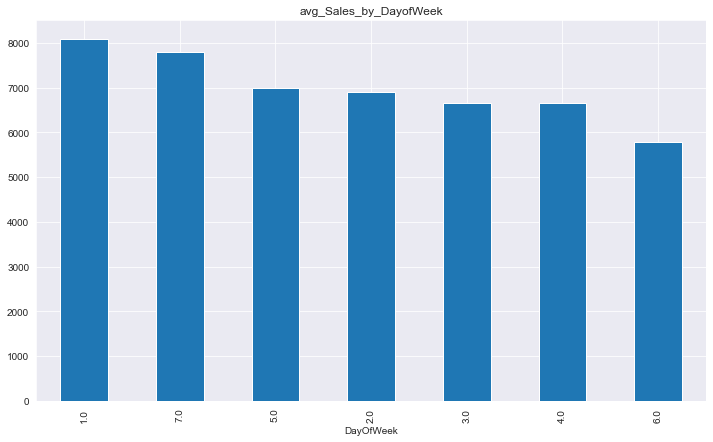

In [107]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, figsize=(12,7))

avg_Sales_by_DayofWeek.plot(ax=ax, kind='bar')

ax.set_title('avg_Sales_by_DayofWeek')

fig;

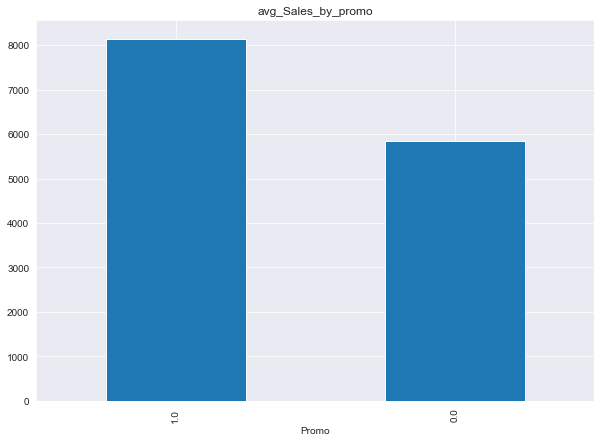

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, figsize=(10,7))

avg_Sales_by_promo.plot(ax=ax, kind='bar')

ax.set_title('avg_Sales_by_promo')

fig;

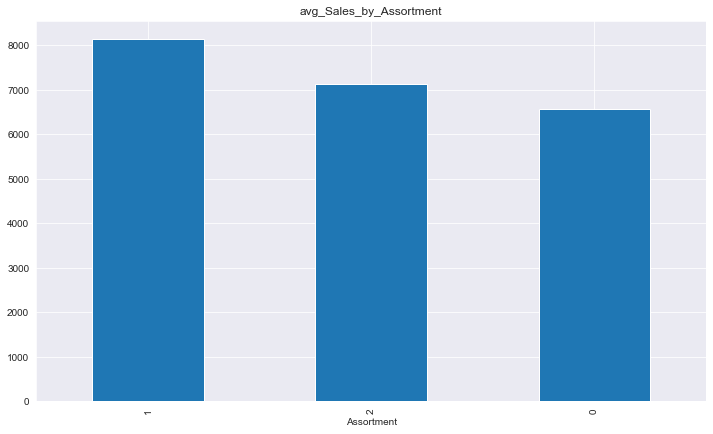

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, figsize=(12,7))

avg_Sales_by_Assortment.plot(ax=ax, kind='bar')

ax.set_title('avg_Sales_by_Assortment')

fig;

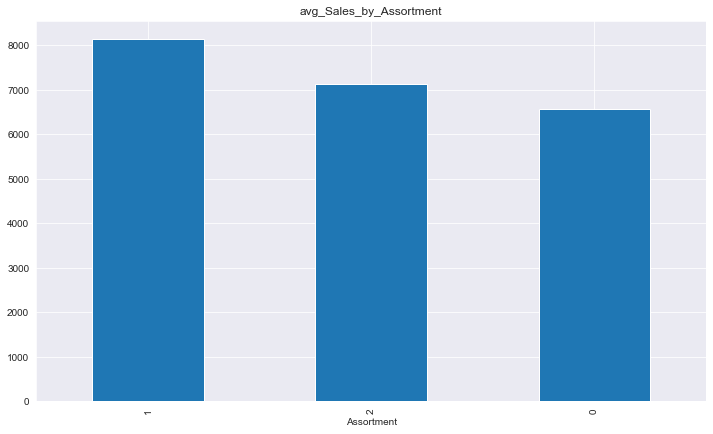

In [110]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, figsize=(12,7))

avg_Sales_by_Assortment.plot(ax=ax, kind='bar')

ax.set_title('avg_Sales_by_Assortment')

fig;

#### Seller Analysis
The "Store" column naming the store id who has the highest sales could be interesting. Maybe there is one "rock star" store who makes drastically more than the others. 

There is definitely a large spread between the agents. Some have an average sales that is one OOM larger than the others.

In [111]:
train_data.groupby("Store")["Sales"].mean().round().sort_values(ascending=False)

Store
817.0     22637.0
262.0     20742.0
1114.0    20096.0
251.0     18792.0
513.0     18588.0
           ...   
198.0      2893.0
254.0      2878.0
208.0      2859.0
543.0      2813.0
307.0      2671.0
Name: Sales, Length: 1115, dtype: float64

## 3. Feature Engineering

We have now seen that many of our categorical columns have a very large number of possible values (some with 200-300). 

This is too many to encoding using One Hot Encoding. 

So instead, we will use mean encoding, putting the average price for each of the potential category values as its new value.

**This helps us get all the columns to numeric format, for use in modelling!**

We will also drop "Address", since it is unique to the property and thus very unlikely to help our model learn.
For the location variables, we will just keep one.


All the rest we will mean encode, and then get started with modeling!

For this initial stage of modeling, we will also drop the column "Method".

In [160]:
data.head()

,Store,DayOfWeek,Sales,Customers_x,Promo,StateHoliday_1,StateHoliday_2,StateHoliday_3,StateHoliday_4,SchoolHoliday,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,DayofMonth,Year-original
0,1115.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,8.0,2005.0,1.0,22.0,2012.0,3,5656.550582,1,4031.311408,2013
1,379.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,8.0,2005.0,0.0,0.0,0.0,0,5656.550582,1,4031.311408,2013
2,378.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,8.0,2012.0,0.0,0.0,0.0,0,5656.550582,1,4031.311408,2013
3,377.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,6.0,2010.0,1.0,18.0,2010.0,1,5656.550582,1,4031.311408,2013
4,376.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,8.0,2012.0,0.0,0.0,0.0,0,5656.550582,1,4031.311408,2013


In [161]:
label_encoder(data, ['StoreType','Assortment' ])

Now, nearly all of our columns are in numeric format, except for date. So, for this first round of modeling, we will also drop date. We can always pick it back up in the future.

Now all of our data is in numeric format! We can now start modeling. 

## 4. Initial Baseline Modeling

In [162]:
# splititng features and target back apart
x_train = train_data.copy(deep=True).drop(columns=["Sales"])
y_train = train_data.loc[:, "Sales"]

### Step 1: Lazy Estimator
Simply predicting the mean price for every house.

In [163]:
lazy_estimator_predictions = pd.DataFrame(y_train.copy())

# using median of entire training set
lazy_estimator_predictions.loc[:,'lazy_predicted_price'] = y_train.mean()
lazy_estimator_predictions.head().round()

,Sales,lazy_predicted_price
85986,4830.0,6839.0
630240,13137.0,6839.0
402540,7776.0,6839.0
113727,6018.0,6839.0
604918,4474.0,6839.0


With the lazy estimator, we are on average $639,810.92 dollars off in our predictions.

In [164]:
lazy_estimator_rmse = compute_rmse(y_train, lazy_estimator_predictions.loc[:, 'lazy_predicted_price'])

RMSE is  3083.72


### Step 2: Initial ML Model
Since this is a regression problem, we will start with linear regression as our model. 


In [256]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'DayofMonth', 'Year-original'],
      dtype='object')

In [261]:
x_train.drop(columns=['StoreType', 'Assortment'], inplace=True)
x_test.drop(columns=['StoreType', 'Assortment'], inplace=True)
CompetitionOpenSinceYear


In [363]:
# splitting data into features and targets 
x = data[data['Sales']!= 0].drop(columns=["Sales", "Customers_x"])
y = data[data['Sales']!= 0].loc[:, "Sales"].drop(columns=["Customers"])

# Removing 15% of data as holdout
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [364]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday_1', 'StateHoliday_2',
       'StateHoliday_3', 'StateHoliday_4', 'SchoolHoliday', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'DayofMonth', 'Year-original'],
      dtype='object')

In [355]:
x_train = x_train[['Store', 'Year', 'Month',
       'Year-original','DayOfWeek', 'Promo', 'Promo2', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment','CompetitionOpenSinceMonth', 'Month',
       'DayofMonth']]
x_test= x_test[['Store', 'Year', 'Month',
       'Year-original','DayOfWeek', 'Promo', 'Promo2', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment','CompetitionOpenSinceMonth', 'Month',
       'DayofMonth']]

In [346]:
linear_regression_model = LinearRegression(normalize=True )
linear_regression_model.fit(x_train, y_train)
linear_regression_predictions = linear_regression_model.predict(x_test)

Just using a simple linear regression cut our RMSE almost in half over the lazy estimator!

In [347]:
linear_regression_rmse = compute_rmse(y_test, linear_regression_predictions)

RMSE is  1903.55


In [185]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday_1', 'StateHoliday_2',
       'StateHoliday_3', 'StateHoliday_4', 'SchoolHoliday', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'DayofMonth', 'Year-original'],
      dtype='object')

In [200]:
combined[combined['Sales']==0].groupby('Open')['Sales'].value_counts().sort_values()

Open  Sales
1.0   0.0          40
0.0   0.0      102584
Name: Sales, dtype: int64

In [186]:
combined.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers_x', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CustomerTraffic', 'CustomerCategory',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [187]:
features2 = [ 'Store', 'DayOfWeek', 'Promo',
       'Year', 'Month', 'DayofMonth'       ]

In [188]:
x_train2= x_train[features2]
x_test2 = x_test[features2]


In [189]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train2, y_train)
linear_regression_predictions = linear_regression_model.predict(x_test2)

In [190]:
linear_regression_rmse = compute_rmse(y_test, linear_regression_predictions)

RMSE is  2809.63


### Step 3: More Sophisticated ML Model
We'll use a random forest, because it:
- is easy to implement
- gives feature importances
- can handle both integer and float values well

In [203]:
x_train.StateHoliday_2.value_counts()

1    351472
0       397
Name: StateHoliday_2, dtype: int64

In [212]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday_1', 'StateHoliday_2',
       'StateHoliday_3', 'StateHoliday_4', 'SchoolHoliday', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'DayofMonth', 'Year-original'],
      dtype='object')

In [381]:
x_train['Year-original'].value_counts()

2013    224522
2014    127347
Name: Year-original, dtype: int64

In [170]:
from sklearn.ensemble import RandomForestRegressor

In [378]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train, np.log(y_train))


RandomForestRegressor()

In [382]:
random_forest_predictions = random_forest_model.predict(x_test)

In [388]:
random_forest_rmse = compute_rmse(y_test, np.exp(random_forest_predictions))

RMSE is  867.36


In [387]:
np.exp(random_forest_predictions)

array([7480.02527498, 8644.01611333, 7306.46846254, ..., 6994.53143612,
       9438.77616803, 3328.77181205])

Training an out-of-the-box random forest further decreased our RMSE.

In [389]:
metric(np.exp(random_forest_predictions),y_test.to_numpy())

13.786767501282277

In [362]:
filename = 'finalized_model.sav'
pickle.dump(random_forest_model, open(filename, 'wb'))

MemoryError: 

<AxesSubplot:>

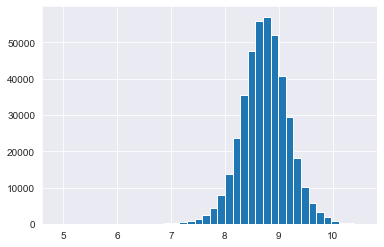

In [377]:
np.log(data[data['Sales']!=0].Sales).hist(bins=40)

<AxesSubplot:>

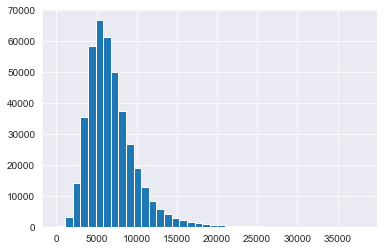

In [390]:
data[data['Sales']!=0].Sales.hist(bins=40)

In [391]:
data


MemoryError: Unable to allocate 26.7 MiB for an array with shape (7, 499419) and data type float64

MemoryError: Unable to allocate 26.7 MiB for an array with shape (7, 499419) and data type float64